In [1]:
# Base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from lifelines import CoxPHFitter
from collections import Counter
from tqdm import tqdm

# Modelling
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

In [2]:
# Import all the data
metadata_raw = pd.read_csv('../data/TCGA.LUAD.metadata.txt', delimiter='\t')
expression_raw = pd.read_csv('../data/TCGA.LUAD.expression.txt', delimiter='\t')
mutations_raw = pd.read_csv('../data/TCGA.LUAD.mutations.txt', delimiter='\t')

exposure_raw = pd.read_csv('../data/exposure.txt', delimiter='\t')
clinical_raw = pd.read_csv('../data/clinical.txt', delimiter='\t')

In [3]:
metadata_raw.head()

,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-05-4244,LUAD,70.0,MALE,[Not Available],Stage IV,Lung Adenocarcinoma,[Not Available],TUMOR FREE,Alive,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN
1,TCGA-05-4249,LUAD,67.0,MALE,[Not Available],Stage IB,Lung Adenocarcinoma,[Not Available],TUMOR FREE,Alive,0.0,1523.0,0.0,1523.0,NaN,NaN,0.0,1523.0,NaN
2,TCGA-05-4250,LUAD,79.0,FEMALE,[Not Available],Stage IIIA,Lung Adenocarcinoma,[Not Available],NaN,Dead,1.0,121.0,NaN,121.0,NaN,NaN,0.0,121.0,NaN
3,TCGA-05-4382,LUAD,68.0,MALE,[Not Available],Stage IB,Lung Adenocarcinoma,[Not Available],TUMOR FREE,Alive,0.0,607.0,0.0,607.0,1.0,334.0,1.0,334.0,NaN
4,TCGA-05-4384,LUAD,66.0,MALE,[Not Available],Stage IIIA,Lung Adenocarcinoma,[Not Available],WITH TUMOR,Alive,0.0,426.0,0.0,426.0,NaN,NaN,1.0,183.0,NaN


In [4]:
expression_raw.head()

,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-05-4244,TCGA-05-4244-01A-01R-1107-07,0.0,10.0113,11.2820,49.5994,848.940,0.0,345.2310,1.0472,...,221.164,517.672,39.7940,292.521,959.246,0.6981,1088.050,2837.94,871.28,575.268
1,TCGA-05-4249,TCGA-05-4249-01A-01R-1107-07,0.0,7.1957,12.4436,90.5117,924.016,0.0,145.2020,1.6098,...,198.589,287.507,62.1376,493.560,1179.330,20.2833,787.506,2351.25,1138.12,690.275
2,TCGA-05-4250,TCGA-05-4250-01A-01R-1107-07,0.0,7.2453,6.0184,49.5366,1140.680,0.0,51.7284,0.0000,...,520.899,1046.840,60.0182,365.415,843.903,26.5274,475.172,5437.45,1170.52,532.869
3,TCGA-05-4382,TCGA-05-4382-01A-01R-1206-07,0.0,11.3311,7.5740,82.8303,807.173,0.0,240.0220,0.4786,...,429.630,753.090,40.4424,346.752,946.687,64.8514,908.159,6770.15,1169.24,663.830
4,TCGA-05-4384,TCGA-05-4384-01A-01R-1755-07,0.0,3.2254,3.4942,72.5351,562.004,0.0,274.2820,0.6109,...,258.302,153.940,80.0244,563.225,1320.710,7.9414,778.864,3341.48,1737.32,723.274


In [5]:
mutations_raw.head()

,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,SIFT,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS
0,TCGA-05-4244,CPN1,0,.,GRCh37,10,101814119,101814119,+,Missense_Mutation,...,deleterious(0),probably_damaging(1),"hmmpanther:PTHR11532:SF7,hmmpanther:PTHR11532,...",MODERATE,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,ATCATGGTTAA,5
1,TCGA-05-4244,MKI67,0,.,GRCh37,10,129902901,129902901,+,Silent,...,.,.,"hmmpanther:PTHR21603,hmmpanther:PTHR21603:SF3,...",LOW,SNV,PASS,NONE,MUTECT|MUSE,AATGTGTTGAT,2
2,TCGA-05-4244,NEBL,0,.,GRCh37,10,21104601,21104606,+,In_Frame_Del,...,.,.,"PROSITE_profiles:PS51216,hmmpanther:PTHR11039,...",MODERATE,deletion,PASS,NONE,INDELOCATOR*|VARSCANI*|PINDEL,CAGGAGTTACACTTAAA,3
3,TCGA-05-4244,RP11-445N18.7,0,.,GRCh37,10,45652518,45652518,+,RNA,...,.,.,.,MODIFIER,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,GTAAAGACTGA,5
4,TCGA-05-4244,ERCC6,0,.,GRCh37,10,50667200,50667200,+,Silent,...,.,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR10799:...",LOW,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,GGCCCGGATGA,5


In [6]:
exposure_raw.head()

,case_submitter_id,patient_id,project_id,age_at_onset,alcohol_days_per_week,alcohol_drinks_per_day,alcohol_history,alcohol_intensity,alcohol_type,asbestos_exposure,...,smoking_frequency,time_between_waking_and_first_smoke,tobacco_smoking_onset_year,tobacco_smoking_quit_year,tobacco_smoking_status,tobacco_use_per_day,type_of_smoke_exposure,type_of_tobacco_used,weight,years_smoked
0,a3fd20b2-e001-44ab-9716-754e5ae70808,TCGA-55-8513,TCGA-LUAD,'--,'--,'--,Not Reported,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
1,25d4ea9e-f773-4f11-bac9-64efdad73211,TCGA-83-5908,TCGA-LUAD,'--,'--,'--,Not Reported,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,45
2,a52e99d6-a61a-439d-b0b1-ca7a0eabcb04,TCGA-95-7948,TCGA-LUAD,'--,'--,'--,Not Reported,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,2
3,27fceec1-3298-4cdd-a4e6-8f5cf34604f0,TCGA-44-5643,TCGA-LUAD,'--,'--,'--,Not Reported,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--
4,2923e404-38f2-437a-b57e-23401fbe0273,TCGA-86-8279,TCGA-LUAD,'--,'--,'--,Not Reported,'--,'--,'--,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--


In [7]:
clinical_raw.head()

,case_id,patient_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,a3fd20b2-e001-44ab-9716-754e5ae70808,TCGA-55-8513,TCGA-LUAD,77,'--,'--,'--,'--,-28284,'--,...,'--,'--,'--,'--,'--,'--,'--,yes,'--,"Pharmaceutical Therapy, NOS"
1,a3fd20b2-e001-44ab-9716-754e5ae70808,TCGA-55-8513,TCGA-LUAD,77,'--,'--,'--,'--,-28284,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
2,25d4ea9e-f773-4f11-bac9-64efdad73211,TCGA-83-5908,TCGA-LUAD,59,'--,'--,'--,'--,-21760,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Pharmaceutical Therapy, NOS"
3,25d4ea9e-f773-4f11-bac9-64efdad73211,TCGA-83-5908,TCGA-LUAD,59,'--,'--,'--,'--,-21760,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"
4,a52e99d6-a61a-439d-b0b1-ca7a0eabcb04,TCGA-95-7948,TCGA-LUAD,42,'--,'--,'--,'--,-15363,'--,...,'--,'--,'--,'--,'--,'--,'--,no,'--,"Radiation Therapy, NOS"


In [8]:
# We don't want to touch the raw data 
meta = metadata_raw.copy()
exp = expression_raw.copy()
mut = mutations_raw.copy()

expo = exposure_raw.copy()
cli = clinical_raw.copy()

# These will be our working datasets.

# Data Preprocessing #

#### Missing Value Imputation ####

##### age #####

In [9]:
age = meta.age_at_initial_pathologic_diagnosis

age = age.fillna(age.mean())

assert np.all(age.notna()), 'There are still NaNs in age column!'

# Convert age to int
age = age.astype(int)

In [10]:
meta.age_at_initial_pathologic_diagnosis = age

#### Create tumor stage ####

In [11]:
# First, we categorize tumor stages into early/late
stages = ['Stage I' if s in ['Stage IB', 'Stage IA', 'Stage I']
                    else 'Stage II' if s in ['Stage IIB', 'Stage IIA', 'Stage II']
                    else 'Stage III' if s in ['Stage IIIB', 'Stage IIIA']
                    else 'Stage IV' if s in 'Stage IV'
                    else 'N/A' if s in ['[Discrepancy]', '[Not Available]']
                    else 'Unknown' for s in meta['ajcc_pathologic_tumor_stage']]

stage = ['Early' if s in ['Stage I', 'Stage II'] else
         'Late' if s in ['Stage III', 'Stage IV'] else
         'N/A'
         for s in stages]

meta.insert(meta.columns.get_loc('ajcc_pathologic_tumor_stage')+1, 'tumor_stage', stage)

### Identify Patients who are Smokers ###

In [12]:
cols = ['patient_id', 'age_at_initial_pathologic_diagnosis', 'gender', 'tumor_stage', 'OS', 'OS.time']
meta_final = meta[cols]
meta_final

,patient_id,age_at_initial_pathologic_diagnosis,gender,tumor_stage,OS,OS.time
0,TCGA-05-4244,70,MALE,Late,0.0,0.0
1,TCGA-05-4249,67,MALE,Early,0.0,1523.0
2,TCGA-05-4250,79,FEMALE,Late,1.0,121.0
3,TCGA-05-4382,68,MALE,Early,0.0,607.0
4,TCGA-05-4384,66,MALE,Late,0.0,426.0
...,...,...,...,...,...,...
507,TCGA-NJ-A55O,56,FEMALE,Early,0.0,13.0
508,TCGA-NJ-A55R,67,MALE,Early,0.0,603.0
509,TCGA-NJ-A7XG,49,MALE,Late,0.0,617.0
510,TCGA-O1-A52J,74,FEMALE,Early,1.0,1798.0


In [13]:
meta2 = meta_final.merge(expo[['patient_id', 'cigarettes_per_day']], on='patient_id')
meta2['cigarettes_per_day'] = meta2.cigarettes_per_day.replace("'--", 0).astype(float)

threshold = 0.5 # If someone smokes >= 1 cigarette(s) per day, we count them as a smoker
meta2.insert(meta2.columns.get_loc('OS'), 'is_smoker', meta2.cigarettes_per_day >= threshold)
meta2 = meta2.drop('cigarettes_per_day', axis=1)

In [14]:
meta2

,patient_id,age_at_initial_pathologic_diagnosis,gender,tumor_stage,is_smoker,OS,OS.time
0,TCGA-05-4244,70,MALE,Late,True,0.0,0.0
1,TCGA-05-4249,67,MALE,Early,True,0.0,1523.0
2,TCGA-05-4250,79,FEMALE,Late,True,1.0,121.0
3,TCGA-05-4382,68,MALE,Early,True,0.0,607.0
4,TCGA-05-4384,66,MALE,Late,True,0.0,426.0
...,...,...,...,...,...,...,...
507,TCGA-NJ-A55O,56,FEMALE,Early,True,0.0,13.0
508,TCGA-NJ-A55R,67,MALE,Early,False,0.0,603.0
509,TCGA-NJ-A7XG,49,MALE,Late,False,0.0,617.0
510,TCGA-O1-A52J,74,FEMALE,Early,True,1.0,1798.0


### Handle Categorical Variables ###

One-hot encoding

In [15]:
meta2 = pd.get_dummies(meta2, columns=['gender', 'tumor_stage', 'is_smoker'], dtype=int)
meta2

,patient_id,age_at_initial_pathologic_diagnosis,OS,OS.time,gender_FEMALE,gender_MALE,tumor_stage_Early,tumor_stage_Late,tumor_stage_N/A,is_smoker_False,is_smoker_True
0,TCGA-05-4244,70,0.0,0.0,0,1,0,1,0,0,1
1,TCGA-05-4249,67,0.0,1523.0,0,1,1,0,0,0,1
2,TCGA-05-4250,79,1.0,121.0,1,0,0,1,0,0,1
3,TCGA-05-4382,68,0.0,607.0,0,1,1,0,0,0,1
4,TCGA-05-4384,66,0.0,426.0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
507,TCGA-NJ-A55O,56,0.0,13.0,1,0,1,0,0,0,1
508,TCGA-NJ-A55R,67,0.0,603.0,0,1,1,0,0,1,0
509,TCGA-NJ-A7XG,49,0.0,617.0,0,1,0,1,0,1,0
510,TCGA-O1-A52J,74,1.0,1798.0,1,0,1,0,0,0,1


In [16]:
meta2.drop(columns=['OS', 'OS.time'], axis=1).to_csv('metadata_final_no_os.csv', index=False)

### Joining to Label and Expression Data ###

In [17]:
labels = pd.read_csv('labels.csv')
labels.head()

,patient_id,label
0,TCGA-05-4244,0
1,TCGA-05-4249,1
2,TCGA-05-4382,0
3,TCGA-05-4384,0
4,TCGA-05-4389,1


In [18]:
gene_expression = pd.read_csv('gene_expression.csv')

gene_expression = gene_expression.drop(columns='sample_type', axis=1)
gene_expression.head()

,patient_id,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|388795,?|390284,?|57714,?|645851,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-05-4244,0.115255,0.097686,-1.940808,-0.033268,1.057022,1.530721,0.136966,0.684342,1.622239,...,-0.745395,0.023953,-0.205987,-0.438921,-0.233740,-1.752495,0.980841,-0.505237,-0.279620,-0.447237
1,TCGA-05-4249,-0.233267,0.219007,-0.289184,0.202607,-0.069052,0.029955,0.027188,-0.067842,0.106420,...,-0.977605,-0.764733,0.780866,0.824841,0.422735,-0.120232,-0.112752,-0.890109,0.314648,0.096801
2,TCGA-05-4250,-0.226146,-0.653582,-1.944270,0.789038,-1.401133,-1.208640,-0.019954,0.562568,-0.684338,...,1.105382,0.969504,0.703722,0.098388,-0.640833,0.045846,-1.820803,0.825152,0.377094,-0.675724
3,TCGA-05-4382,0.248854,-0.384813,-0.533564,-0.173685,0.583903,0.123771,-0.210492,-0.304392,2.015219,...,0.688824,0.527161,-0.170358,-0.028243,-0.275621,0.608923,0.369427,1.273709,0.374660,-0.019820
4,TCGA-05-4384,-1.015130,-1.252003,-0.898805,-1.181021,0.757503,-0.013923,0.260217,0.220563,0.982440,...,-0.410419,-1.600654,1.344431,1.144063,0.782634,-0.680088,-0.150073,-0.171071,1.255729,0.236221


In [19]:
data = pd.merge(pd.merge(labels, meta2, on='patient_id'), gene_expression, on='patient_id')

In [20]:
data.head()

,patient_id,label,age_at_initial_pathologic_diagnosis,OS,OS.time,gender_FEMALE,gender_MALE,tumor_stage_Early,tumor_stage_Late,tumor_stage_N/A,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-05-4244,0,70,0.0,0.0,0,1,0,1,0,...,-0.745395,0.023953,-0.205987,-0.438921,-0.233740,-1.752495,0.980841,-0.505237,-0.279620,-0.447237
1,TCGA-05-4249,1,67,0.0,1523.0,0,1,1,0,0,...,-0.977605,-0.764733,0.780866,0.824841,0.422735,-0.120232,-0.112752,-0.890109,0.314648,0.096801
2,TCGA-05-4382,0,68,0.0,607.0,0,1,1,0,0,...,0.688824,0.527161,-0.170358,-0.028243,-0.275621,0.608923,0.369427,1.273709,0.374660,-0.019820
3,TCGA-05-4384,0,66,0.0,426.0,0,1,0,1,0,...,-0.410419,-1.600654,1.344431,1.144063,0.782634,-0.680088,-0.150073,-0.171071,1.255729,0.236221
4,TCGA-05-4389,1,70,0.0,1369.0,0,1,1,0,0,...,0.604849,0.750372,1.330608,1.397679,-0.065455,0.673791,-1.420624,-0.711757,-0.833433,0.356558


In [21]:
assert ~np.all(data.isnull().any(axis=1)), 'There exist null values!'

In [22]:
# Finally, remove patient id for training
master = data.drop(columns=['patient_id', 'OS', 'OS.time'], axis=1)

In [23]:
#master = master.iloc[:, :9]
master

,label,age_at_initial_pathologic_diagnosis,gender_FEMALE,gender_MALE,tumor_stage_Early,tumor_stage_Late,tumor_stage_N/A,is_smoker_False,is_smoker_True,?|100133144,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,0,70,0,1,0,1,0,0,1,0.115255,...,-0.745395,0.023953,-0.205987,-0.438921,-0.233740,-1.752495,0.980841,-0.505237,-0.279620,-0.447237
1,1,67,0,1,1,0,0,0,1,-0.233267,...,-0.977605,-0.764733,0.780866,0.824841,0.422735,-0.120232,-0.112752,-0.890109,0.314648,0.096801
2,0,68,0,1,1,0,0,0,1,0.248854,...,0.688824,0.527161,-0.170358,-0.028243,-0.275621,0.608923,0.369427,1.273709,0.374660,-0.019820
3,0,66,0,1,0,1,0,0,1,-1.015130,...,-0.410419,-1.600654,1.344431,1.144063,0.782634,-0.680088,-0.150073,-0.171071,1.255729,0.236221
4,1,70,0,1,1,0,0,0,1,-0.816478,...,0.604849,0.750372,1.330608,1.397679,-0.065455,0.673791,-1.420624,-0.711757,-0.833433,0.356558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,0,56,1,0,1,0,0,0,1,0.593944,...,-0.832927,-0.431204,-0.148779,-0.154760,0.222568,-0.210608,-0.386059,0.289729,0.667480,-0.396243
402,0,67,0,1,1,0,0,1,0,-0.069018,...,-1.495877,-0.170338,0.329302,0.156824,1.156270,0.476298,-0.242561,-0.339250,1.557140,-0.263652
403,0,49,0,1,0,1,0,1,0,1.749735,...,-2.016211,-1.461710,-2.061653,-1.762218,0.543399,-0.541973,-1.441193,-1.226014,0.813458,-1.338024
404,1,74,1,0,1,0,0,0,1,0.486836,...,-1.826732,-0.432321,2.537119,1.141717,0.724190,-1.841894,-0.135198,0.430325,0.959205,-1.000029


In [24]:
## getting the labels for the model
y = master['label']

# getting the features for the model
X = master.drop(columns='label', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train.shape

(324, 17075)

In [27]:
y_train.shape

(324,)

### Cross Validation ###

In [28]:
lasso = Lasso()

In [29]:
cv_results = cross_validate(lasso, X, y, scoring=('roc_auc'))
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [30]:
cv_results['test_score']

array([0.5, 0.5, 0.5, 0.5, 0.5])

### SVM ###

In [31]:
%%time
classifier = svm.SVC(kernel='linear')
classi = classifier.fit(X_train, y_train)

CPU times: user 31.8 s, sys: 1min 57s, total: 2min 29s
Wall time: 19.1 s


In [32]:
y_pred = classifier.predict(X_test)

In [33]:
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4878048780487805


In [34]:
metrics.f1_score(y_test, y_pred) # binary so no need for avg

0.5227272727272727

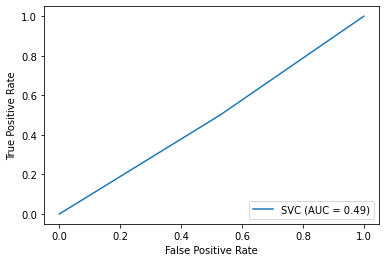

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SVC')

display.plot()
plt.show()

In [36]:
tpr

array([0. , 0.5, 1. ])

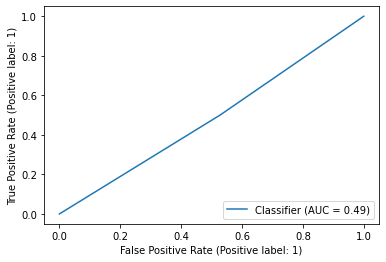

In [37]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)
plt.show()

### Cross Validation with SVM ###

In [38]:
cv_results = cross_validate(classifier, X, y, scoring=('roc_auc'))
sorted(cv_results.keys())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_350/3247316247.py", line 1, in <module>
    cv_results = cross_validate(classifier, X, y, scoring=('roc_auc'))
  File "/home/dliau/.local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 266, in cross_validate
    results = parallel(
  File "/home/dliau/.local/lib/python3.9/site-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/home/dliau/.local/lib/python3.9/site-packages/joblib/parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "/home/dliau/.local/lib/python3.9/site-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/dliau/.local/lib/python3.9/site-packages/joblib/parallel.py", line 819, in _di

TypeError: object of type 'NoneType' has no len()

In [ ]:
cv_results['test_score']